In [1]:
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits
%matplotlib inline
%run Fraunhofer.py

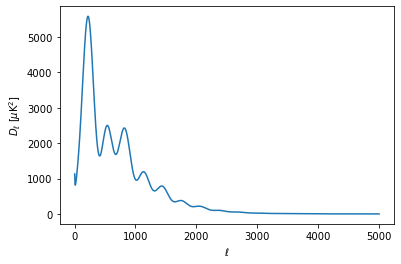

In [2]:
(ell, DlTT) = np.loadtxt('/Users/zhaoyuhuai/Desktop/SeniorProj/CAMB_fiducial_cosmo_scalCls.dat.txt',usecols=(0, 1), unpack=True)
plt.plot(ell,DlTT)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

map mean: -21.956233418754593 map rms: 99.12082087164593


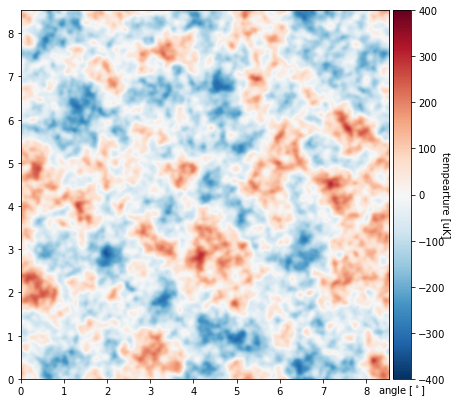

<Figure size 432x288 with 0 Axes>

In [5]:
## variables to set up the size of the map
N = 2**10  # this is the number of pixels in a linear dimension
            ## since we are using lots of FFTs this should be a factor of 2^N
pix_size  = 0.5 # size of a pixel in arcminutes

## variables to set up the map plots
c_min = -400  # minimum for color bar
c_max = 400   # maximum for color bar
X_width = N*pix_size/60.  # horizontal map width in degrees
Y_width = N*pix_size/60.  # vertical map width in degrees


def make_CMB_T_map(N,pix_size,ell,DlTT):
    "makes a realization of a simulated CMB sky map given an input DlTT as a function of ell," 
    "the pixel size (pix_size) required and the number N of pixels in the linear dimension."
    #np.random.seed(100)
    # convert Dl to Cl
    ClTT = DlTT * 2 * np.pi / (ell*(ell+1.))
    ClTT[0] = 0. # set the monopole and the dipole of the Cl spectrum to zero
    ClTT[1] = 0.

    # make a 2D real space coordinate system
    onesvec = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) /(N-1.) # create an array of size N between -0.5 and +0.5
    # compute the outer product matrix: X[i, j] = onesvec[i] * inds[j] for i,j 
    # in range(N), which is just N rows copies of inds - for the x dimension
    X = np.outer(onesvec,inds) 
    # compute the transpose for the y dimension
    Y = np.transpose(X)
    # radial component R
    R = np.sqrt(X**2. + Y**2.)
    
    # now make a 2D CMB power spectrum
    pix_to_rad = (pix_size/60. * np.pi/180.) # going from pix_size in arcmins to degrees and then degrees to radians
    ell_scale_factor = 2. * np.pi /pix_to_rad  # now relating the angular size in radians to multipoles
    ell2d = R * ell_scale_factor # making a fourier space analogue to the real space R vector
    ClTT_expanded = np.zeros(int(ell2d.max())+1) 
    # making an expanded Cl spectrum (of zeros) that goes all the way to the size of the 2D ell vector
    ClTT_expanded[0:(ClTT.size)] = ClTT # fill in the Cls until the max of the ClTT vector

    # the 2D Cl spectrum is defined on the multiple vector set by the pixel scale
    CLTT2d = ClTT_expanded[ell2d.astype(int)] 
    #plt.imshow(np.log(CLTT2d))
       
    
    # now make a realization of the CMB with the given power spectrum in real space
    random_array_for_T = np.random.normal(0,1,(N,N))
    FT_random_array_for_T = np.fft.fft2(random_array_for_T)   # take FFT since we are in Fourier space 
    
    FT_2d = np.sqrt(CLTT2d) * FT_random_array_for_T # we take the sqrt since the power spectrum is T^2
    #plt.imshow(np.real(FT_2d))
    
    #FT_withbeam = screen['FFT_E'] + FT_2d # convolve map with beam
        
    
    ## make a plot of the 2D cmb simulated map in Fourier space, note the x and y axis labels need to be fixed
    #Plot_CMB_Map(np.real(np.conj(FT_2d)*FT_2d*ell2d * (ell2d+1)/2/np.pi),0,np.max(np.conj(FT_2d)*FT_2d*ell2d * (ell2d+1)/2/np.pi),ell2d.max(),ell2d.max())  ###
    
    # move back from ell space to real space
    CMB_T = np.fft.ifft2(np.fft.fftshift(FT_2d)) 
    # move back to pixel space for the map
    CMB_T = CMB_T/(pix_size /60.* np.pi/180.)
    # we only want to plot the real component
    CMB_T = np.real(CMB_T)

    ## return the map
    return(CMB_T)
  ###############################

def Plot_CMB_Map(Map_to_Plot,c_min,c_max,X_width,Y_width):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    print("map mean:",np.mean(Map_to_Plot),"map rms:",np.std(Map_to_Plot))
    plt.gcf().set_size_inches(7, 7)
    im = plt.imshow(Map_to_Plot, interpolation='bilinear', origin='lower',cmap=cm.RdBu_r)
    im.set_clim(c_min,c_max)
    ax=plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cbar = plt.colorbar(im, cax=cax)
    #cbar = plt.colorbar()
    im.set_extent([0,X_width,0,Y_width])
    plt.ylabel('angle $[^\circ]$')
    plt.xlabel('angle $[^\circ]$')
    cbar.set_label('tempearture [uK]', rotation=270)
    
    plt.show()
    return(0)
  ###############################

## make a CMB T map
CMB_T = make_CMB_T_map(N,pix_size,ell,DlTT)
Plot_CMB_Map(CMB_T,c_min,c_max,X_width,Y_width)
plt.clf()

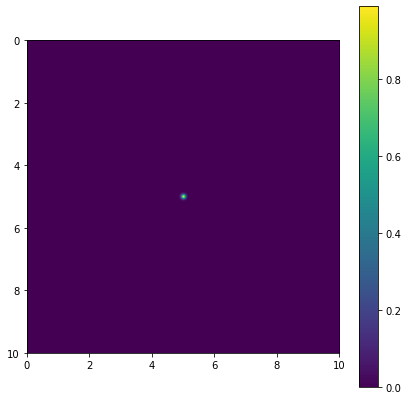

In [37]:
screen = {}
screen['N'] = 1024
screen['D'] = 10
Initialize(screen)
center = (screen['D']/2, screen['D']/2)
MultByGaussian(screen, center, 0.05)
InCircle(screen, center, 2.0)
ScreenFFT(screen)

# lam = 0.002 #m wavelength
# kphot = 2*np.pi/lam
# thetamaxdeg = 2.0
# thetamax = 2*np.pi/180. # 2 degrees in radians
# theta_vec = np.linspace(-thetamax,thetamax,1024) 
# II0 = Project_I_on_thetagrid(theta_vec,screen,lam) 
plt.gcf().set_size_inches(7, 7)
plt.imshow(screen['E'],extent=(0,screen['D'],screen['D'],0))
plt.colorbar()


In [13]:
screen = {}
screen['N'] = 1024
screen['D'] = 10
Initialize(screen)
center = (screen['D']/2, screen['D']/2)
MultByGaussian(screen, center, 0.005)
InCircle(screen, center, 2.0)
c2 = (center[0], center[1])
#CircleAtten(screen1,c2,0.01,1.5)
#CircleAtten(screen,c2,0.01,1.0*np.exp(np.pi/2*1j))
ScreenFFT(screen)

# lam = 0.002 #m wavelength
# kphot = 2*np.pi/lam
# thetamaxdeg = 2.0
# thetamax = 2*np.pi/180. # 2 degrees in radians
# theta_vec = np.linspace(-thetamax,thetamax,1024) 
# II0 = Project_I_on_thetagrid(theta_vec,screen,lam) 
#plt.gcf().set_size_inches(7, 7)
#plt.imshow(screen1['E'],extent=(0,screen1['D'],screen1['D'],0))
#plt.colorbar()

Text(0.5, 1.0, 'CMB_T convolved with gaussian beam')

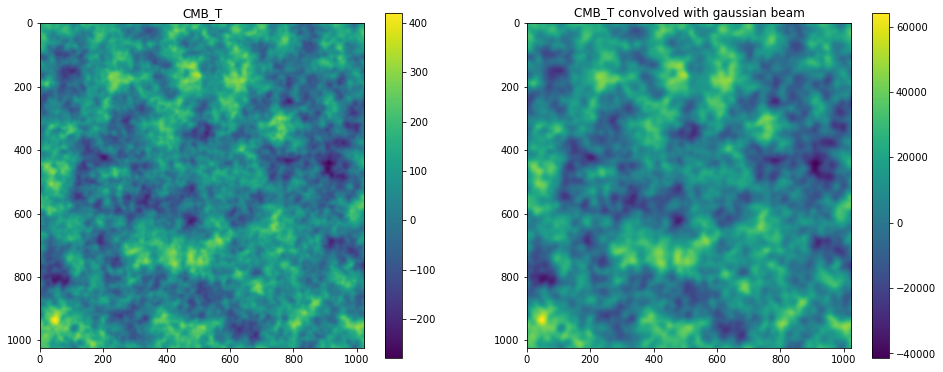

In [38]:
# FT_beam = np.fft.fftshift(np.fft.fft2(screen['E'])) 
# #FT_beam1 = np.fft.fftshift(np.fft.fft2(screen1['E']))
# FT_map = np.fft.fftshift(np.fft.fft2(CMB_T)) 
# conv_map = np.fft.fftshift(np.fft.ifft2(FT_beam*FT_map))
#conv_map1 = np.fft.fftshift(np.real(np.fft.ifft2(FT_beam1*FT_map))) #get rid of np.real check imag components of conv_map 

FT_gaussian = np.fft.fft2(np.fft.fftshift(screen['E'])) # first add the shift so that it is central
FT_Map = np.fft.fft2(np.fft.fftshift(CMB_T)) #shift the map too
convolved_map = np.fft.fftshift(np.real(np.fft.ifft2(FT_gaussian*FT_Map))) 
plt.rcParams['figure.figsize'] = [16, 14]
plt.subplot(2,2,1)
plt.imshow(CMB_T)
plt.colorbar()
plt.title('CMB_T')
plt.subplot(2,2,2)
#plt.imshow(np.real(conv_map))
#plt.imshow(screen['E'])
plt.imshow(convolved_map)
plt.colorbar()
plt.title('CMB_T convolved with gaussian beam')
# plt.subplot(2,2,3)
# plt.imshow(np.real(conv_map1)**2)
# plt.colorbar()
# plt.title('CMB_T convolved with (gaussian beam + phase shift)')
# plt.subplot(2,2,4)
# plt.imshow(np.real(conv_map1)-np.real(conv_map)**2))
# plt.colorbar()
# plt.title('difference')


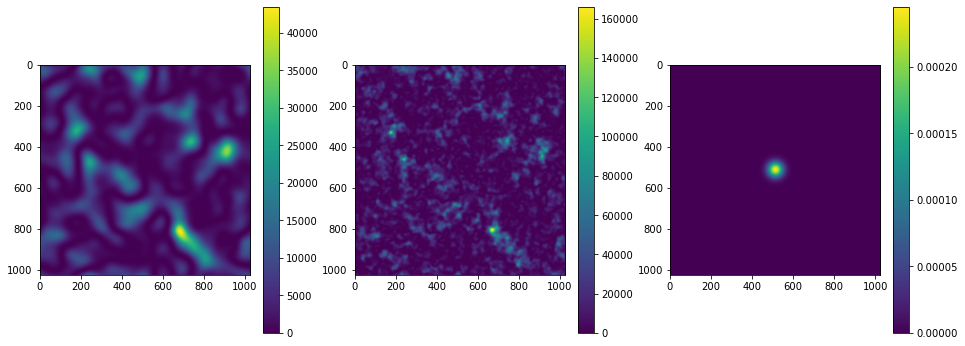

In [170]:
beam_size_fwhp = 1.25

def convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,Map):
    "convolves a map with a Gaussian beam pattern.  NOTE: pix_size and beam_size_fwhp need to be in the same units" 
    # make a 2d gaussian 
    gaussian = make_2d_gaussian_beam(N,pix_size,beam_size_fwhp)
  
    # do the convolution
    FT_gaussian = np.fft.fft2(np.fft.fftshift(gaussian)) # first add the shift so that it is central
    FT_Map = np.fft.fft2(np.fft.fftshift(Map)) #shift the map too
    convolved_map = np.fft.fftshift(np.real(np.fft.ifft2(FT_gaussian*FT_Map))) 
    
    # return the convolved map
    return(convolved_map)
  ###############################   

def make_2d_gaussian_beam(N,pix_size,beam_size_fwhp):
     # make a 2d coordinate system
    N=int(N)
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) * pix_size
    X = np.outer(ones,inds)
    Y = np.transpose(X)
    R = np.sqrt(X**2. + Y**2.)
    #plt.title('Radial co ordinates')
    #plt.imshow(R)
  
    # make a 2d gaussian 
    beam_sigma = beam_size_fwhp / np.sqrt(8.*np.log(2))
    gaussian = np.exp(-.5 *(R/beam_sigma)**2.)
    gaussian = gaussian / np.sum(gaussian)
    # return the gaussian
    #plt.imshow(gaussian)
    return(gaussian)
  ###############################  
    
    
## convolve the signal part of the map

CMB_T_convolved = convolve_map_with_gaussian_beam(N,pix_size, 30,CMB_T)
plt.rcParams['figure.figsize'] = [16, 6]
plt.subplot(1,3,1)
plt.imshow(np.real(CMB_T_convolved)**2)
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(np.real(CMB_T)**2)
plt.colorbar()
plt.subplot(1,3,3)
gauss = make_2d_gaussian_beam(N,pix_size,30)
plt.imshow(gauss)
plt.colorbar()
#p=Plot_CMB_Map(CMB_T_convolved,c_min,c_max,X_width,Y_width)

In [ ]:
# plot 2D Cll (Dll) (like in Fourier space) 。
# mult by our mask (like a phase shift) & gaussian random field
# iFFT --> CMB map with our systematics

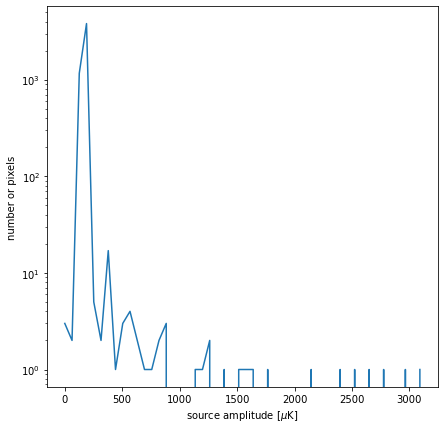

map mean: 0.9981904398361175 map rms: 16.35788108719861


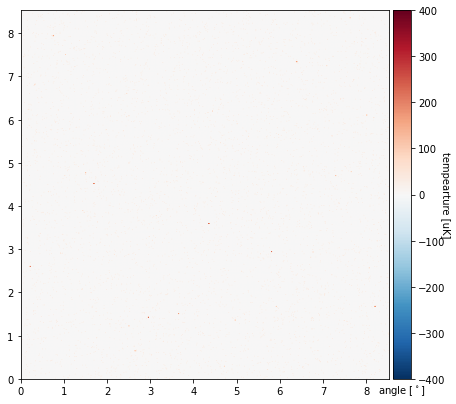

In [27]:
### paramaters to set up the Poisson point source distribution
Number_of_Sources  = 5000.
Amplitude_of_Sources = 200.
Number_of_Sources_EX = 50.
Amplitude_of_Sources_EX = 1000.

def Poisson_source_component(N,pix_size,Number_of_Sources,Amplitude_of_Sources):
    "makes a realization of a naive Poisson-distributed point source map"
    "takes in the number of pixels, the size of the pixels and the number and amplitude of the sources"
    PSMap = np.zeros([int(N),int(N)])
    i = 0.
    # we throw random numbers repeatedly with amplitudes given by a Poisson distribution around the mean amplitude
    while (i < Number_of_Sources):
        pix_x = int(N*np.random.rand())
        pix_y = int(N*np.random.rand()) 
        PSMap[pix_x,pix_y] += np.random.poisson(Amplitude_of_Sources)
        i = i + 1

    return(PSMap)    
  ############################### 

def Exponential_source_component(N,pix_size,Number_of_Sources_EX,Amplitude_of_Sources_EX):
    "makes a realization of a naive exponentially-distributed point source map"
    PSMap = np.zeros([int(N),int(N)])
    i = 0.
    # we throw random numbers repeatedly with amplitudes given by an exponential distribution around the mean amplitude
    while (i < Number_of_Sources_EX):
        pix_x = int(N*np.random.rand()) 
        pix_y = int(N*np.random.rand()) 
        
        PSMap[pix_x,pix_y] += np.random.exponential(Amplitude_of_Sources_EX)
        i = i + 1

    return(PSMap)    
  ############################### 
    
## make a point source map

PSMap = Poisson_source_component(N,pix_size,Number_of_Sources,Amplitude_of_Sources) 
PSMap +=  Exponential_source_component(N,pix_size,Number_of_Sources_EX,Amplitude_of_Sources_EX)

hist,bin_edges = np.histogram(PSMap,bins = 50,range=[.001,PSMap.max()])
plt.figure(figsize=(7,7))
plt.semilogy(bin_edges[0:-1],hist)
plt.xlabel('source amplitude [$\mu$K]')
plt.ylabel('number or pixels')
plt.show()

p=Plot_CMB_Map(PSMap,c_min,c_max,X_width,Y_width)    

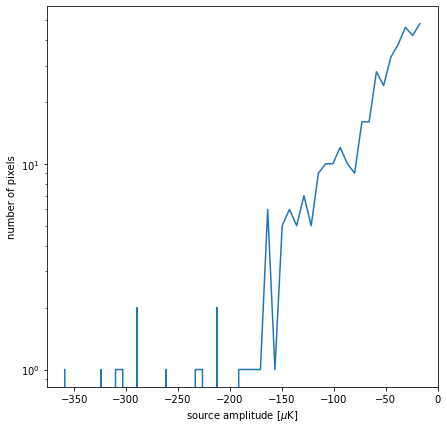

map mean: -13.836971892491407 map rms: 7.307636761948398


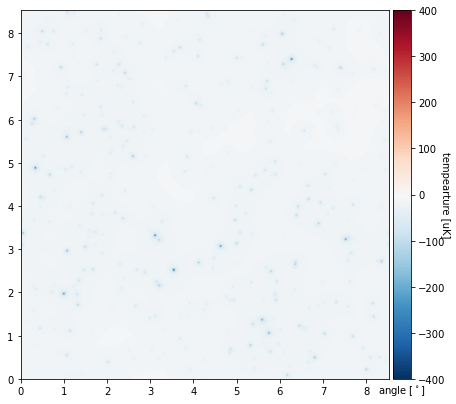

In [21]:
### paramaters to set up the SZ point sources
Number_of_SZ_Clusters  = 500
Mean_Amplitude_of_SZ_Clusters = 50
SZ_beta = 0.86
SZ_Theta_core = 1.0

def SZ_source_component(N,pix_size,Number_of_SZ_Clusters,Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,do_plots):
    "makes a realization of a naive SZ map"
    N=int(N)
    SZMap = np.zeros([N,N])
    SZcat = np.zeros([3,Number_of_SZ_Clusters]) ## catalogue of SZ sources, X, Y, amplitude
    # make a distribution of point sources with varying amplitude
    i = 0
    while (i < Number_of_SZ_Clusters):
        pix_x = int(N*np.random.rand())
        pix_y = int(N*np.random.rand())
        pix_amplitude = np.random.exponential(Mean_Amplitude_of_SZ_Clusters)*(-1.)
        SZcat[0,i] = pix_x
        SZcat[1,i] = pix_y
        SZcat[2,i] = pix_amplitude
        SZMap[pix_x,pix_y] += pix_amplitude
        i = i + 1
    if (do_plots):
        hist,bin_edges = np.histogram(SZMap,bins = 50,range=[SZMap.min(),-10])
        plt.figure(figsize=(7,7))
        plt.semilogy(bin_edges[0:-1],hist)
        plt.xlabel('source amplitude [$\mu$K]')
        plt.ylabel('number of pixels')
        plt.show()
    
    # make a beta function
    beta = beta_function(int(N),pix_size,SZ_beta,SZ_Theta_core)
    
    # convolve the beta function with the point source amplitude to get the SZ map
    # NOTE: you should go back to the Intro workshop for more practice with convolutions!
    FT_beta = np.fft.fft2(np.fft.fftshift(beta))
    FT_SZMap = np.fft.fft2(np.fft.fftshift(SZMap))
    SZMap = np.fft.fftshift(np.real(np.fft.ifft2(FT_beta*FT_SZMap)))
    
    # return the SZ map
    return(SZMap,SZcat)    
  ############################### 
def beta_function(N,pix_size,SZ_beta,SZ_Theta_core):
  # make a beta function

    N=int(N)
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) * pix_size
    X = np.outer(ones,inds)
    Y = np.transpose(X)
    # compute the same real-space R function as before for the PS
    R = np.sqrt(X**2. + Y**2.)
    
    beta = (1 + (R/SZ_Theta_core)**2.)**((1-3.*SZ_beta)/2.)

    # return the beta function map
    return(beta)
  ############################### 
    
## make a point source map

SZMap,SZCat = SZ_source_component(N,pix_size,Number_of_SZ_Clusters,Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,True)

  
p=Plot_CMB_Map(SZMap,c_min,c_max,X_width,Y_width)

map mean: -18.46869044962088 map rms: 94.45271511409896


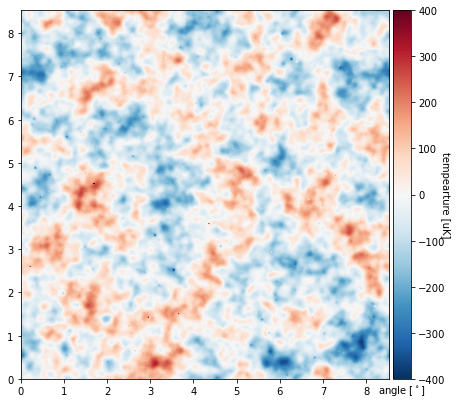

In [28]:
## remake the CMB map from the pervious excercise
CMB_T = make_CMB_T_map(N,pix_size,ell,DlTT)

## add all the componets together
total_map = CMB_T + PSMap + SZMap

p=Plot_CMB_Map(total_map,c_min,c_max,X_width,Y_width)

In [33]:
# testtttt

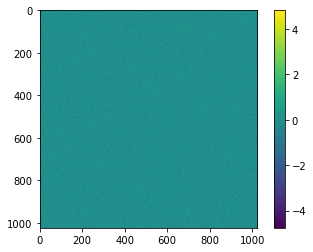

In [90]:
Gauss_test = np.random.normal(0,1,(1024,1024))
Gauss_test1d = np.random.normal(0,1,1024)
plt.imshow(Gauss_test)
plt.colorbar()

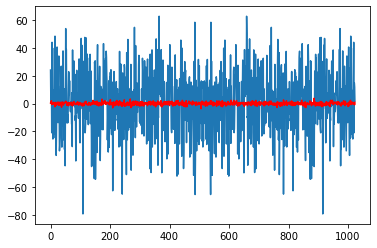

In [91]:
plt.plot(np.real(np.fft.fft(Gauss_test1d)))
plt.plot(Gauss_test1d,color='red')

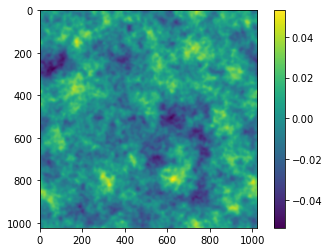

In [96]:
mapFT = np.sqrt(CLTT2d)*np.fft.fft2(Gauss_test)
mapreal = np.fft.ifft2(np.fft.fftshift(mapFT))
plt.imshow(np.real(mapreal))
plt.colorbar()

In [64]:
## variables to set up the size of the map
N = 2**10  # this is the number of pixels in a linear dimension
            ## since we are using lots of FFTs this should be a factor of 2^N
pix_size  = 0.5 # size of a pixel in arcminutes

## variables to set up the map plots
c_min = -400  # minimum for color bar
c_max = 400   # maximum for color bar
X_width = N*pix_size/60.  # horizontal map width in degrees
Y_width = N*pix_size/60.  # vertical map width in degrees
radius=0.02

In [65]:
ClTT = DlTT * 2 * np.pi / (ell*(ell+1.))
ClTT[0] = 0. # set the monopole and the dipole of the Cl spectrum to zero
ClTT[1] = 0.

    # make a 2D real space coordinate system
onesvec = np.ones(N)
inds  = (np.arange(N)+.5 - N/2.) /(N-1.) # create an array of size N between -0.5 and +0.5
    # compute the outer product matrix: X[i, j] = onesvec[i] * inds[j] for i,j 
    # in range(N), which is just N rows copies of inds - for the x dimension
X = np.outer(onesvec,inds) 
    # compute the transpose for the y dimension
Y = np.transpose(X)
    # radial component R
R = np.sqrt(X**2. + Y**2.)
    
    # now make a 2D CMB power spectrum
pix_to_rad = (pix_size/60. * np.pi/180.) # going from pix_size in arcmins to degrees and then degrees to radians
ell_scale_factor = 2. * np.pi /pix_to_rad  # now relating the angular size in radians to multipoles
ell2d = R * ell_scale_factor # making a fourier space analogue to the real space R vector
ClTT_expanded = np.zeros(int(ell2d.max())+1) 
    # making an expanded Cl spectrum (of zeros) that goes all the way to the size of the 2D ell vector
ClTT_expanded[0:(ClTT.size)] = ClTT # fill in the Cls until the max of the ClTT vector

    # the 2D Cl spectrum is defined on the multiple vector set by the pixel scale
CLTT2d = ClTT_expanded[ell2d.astype(int)] 
    #plt.imshow(np.log(CLTT2d))
       
    
    # now make a realization of the CMB with the given power spectrum in real space
random_array_for_T = np.random.normal(0,1,(N,N))
FT_random_array_for_T = np.fft.fft2(random_array_for_T)   # take FFT since we are in Fourier space 
    
FT_2d = np.sqrt(CLTT2d) * FT_random_array_for_T # we take the sqrt since the power spectrum is T^2
    

cut_ap = np.where(R<radius,1,0) 
FT_2d=FT_2d*cut_ap

    # move back from ell space to real space
CMB_T = np.fft.ifft2(np.fft.fftshift(FT_2d)) 
    # move back to pixel space for the map
CMB_T = CMB_T/(pix_size /60.* np.pi/180.)
    # we only want to plot the real component
CMB_T = np.real(CMB_T)

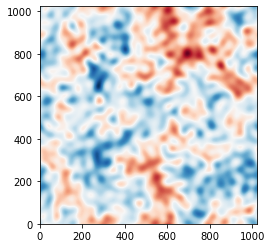

In [66]:
plt.imshow(CMB_T, interpolation='bilinear', origin='lower',cmap=cm.RdBu_r)

(400.0, 600.0)

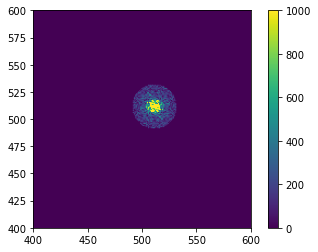

In [67]:
plt.imshow(np.abs(FT_2d),vmax=1000)
plt.colorbar()
plt.xlim(400,600)
plt.ylim(400,600)